In [60]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

### Load data and merge dfs: user data + purchases data

In [4]:
customer_data = pd.read_csv('./data/AB_testing/user_demographics_v1.csv')
customer_data['date'] = pd.to_datetime(customer_data['reg_date']).dt.date.astype('str')
customer_data.drop('reg_date', axis=1, inplace=True)
display(customer_data[:2])

app_purchases = pd.read_csv('./data/AB_testing/purchase_data_v1.csv')
app_purchases['date'] = pd.to_datetime(app_purchases['date']).astype('str')
display(app_purchases[:2])

,uid,device,gender,country,age,date
0,54030035.0,and,M,USA,19,2017-06-29
1,72574201.0,iOS,F,TUR,22,2018-03-05


,date,uid,sku,price
0,2017-07-10,41195147,sku_three_499,499
1,2017-07-15,41195147,sku_three_499,499


**merge data frames**

on uid field

In [8]:
uid_combined_data = app_purchases.merge(customer_data, on=['uid'], how='inner')
display(uid_combined_data[:3])
print(len(uid_combined_data))

,date_x,uid,sku,price,device,gender,country,age,date_y
0,2017-07-10,41195147,sku_three_499,499,and,M,BRA,17,2017-06-26
1,2017-07-15,41195147,sku_three_499,499,and,M,BRA,17,2017-06-26
2,2017-11-12,41195147,sku_four_599,599,and,M,BRA,17,2017-06-26


9006


on uid and date fields

In [9]:
uid_date_combined_data = app_purchases.merge(customer_data, on=['uid', 'date'], how='inner')

# Examine the results 
display(uid_date_combined_data[:3])
print(len(uid_date_combined_data))

,date,uid,sku,price,device,gender,country,age
0,2016-03-30,94055095,sku_four_599,599,iOS,F,BRA,16
1,2015-10-28,69627745,sku_one_199,199,and,F,BRA,18
2,2017-02-02,11604973,sku_seven_1499,499,and,F,USA,16


35


### Groupby and aggregate examples
- groupby then call agregate on the groupby object
- potential groups: country, device, gender and age

merge user_demographics_v1 and purchase_data_v1 into purchase_data

In [29]:
customer_data = pd.read_csv('./data/AB_testing/user_demographics_v1.csv')
customer_data['reg_date'] = pd.to_datetime(pd.to_datetime(customer_data['reg_date']).dt.date)

app_purchases = pd.read_csv('./data/AB_testing/purchase_data_v1.csv')
app_purchases['date'] = pd.to_datetime(app_purchases['date'])

purchase_data = app_purchases.merge(customer_data, on=['uid'], how='inner')
display(purchase_data[:3])

,date,uid,sku,price,reg_date,device,gender,country,age
0,2017-07-10,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17
1,2017-07-15,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17
2,2017-11-12,41195147,sku_four_599,599,2017-06-26,and,M,BRA,17


,date,uid,sku,price,reg_date,device,gender,country,age
0,2017-07-10,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17
1,2017-07-15,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17
2,2017-11-12,41195147,sku_four_599,599,2017-06-26,and,M,BRA,17


In [30]:
purchase_summary = purchase_data.agg({'price': ['mean', 'median'], 'age': ['mean', 'median']})
print(purchase_summary)

             price        age
mean    406.772596  23.922274
median  299.000000  21.000000


In [31]:
data_grp = purchase_data.groupby(by = ['device', 'gender'], axis=0, as_index=False)
print(data_grp.agg({'price': ['mean', 'median', 'std']}))

  device gender       price                   
                       mean median         std
0    and      F  400.747504    299  179.984378
1    and      M  416.237308    499  195.001520
2    iOS      F  404.435330    299  181.524952
3    iOS      M  405.272401    299  196.843197


In [32]:
data_grp = purchase_data.groupby(by=['country', 'device'], axis=0, as_index=False)
print(data_grp['price'].agg(['mean','median', 'std'])[:6])

                      mean  median         std
country device                                
BRA     and     412.985594     499  190.280551
        iOS     404.739300     299  193.457090
CAN     and     406.826087     499  187.210190
        iOS     386.573964     299  183.936864
DEU     and     402.474903     299  182.045891
        iOS     417.639798     499  172.928326


we can pass dictionaries to agg

In [33]:
print(data_grp.agg({'price': ['mean', 'min', 'max'],
                    'age': ['mean', 'min', 'max']})[:5])

  country device       price                 age        
                        mean min  max       mean min max
0     BRA    and  412.985594  99  899  23.913565  15  62
1     BRA    iOS  404.739300  99  899  23.975681  15  66
2     CAN    and  406.826087  99  899  23.282609  15  49
3     CAN    iOS  386.573964  99  899  25.023669  15  57
4     DEU    and  402.474903  99  899  23.814672  15  66


or custom functions

In [21]:
#remove top and bottom 10% before averaging
def truncated_mean(data):
    top_val = data.quantile(.9)
    bot_val = data.quantile(.1)

    trunc_data = data[(data <= top_val) & (data >= bot_val)]
    mean = trunc_data.mean()

    return(mean)

print(data_grp.agg({'price': [truncated_mean,'mean', 'min', 'max'],
                    'age': [truncated_mean,'mean', 'min', 'max']})[:5])

  country device          price                                 age  \
                 truncated_mean        mean min  max truncated_mean   
0     BRA    and     403.545455  412.985594  99  899      22.798977   
1     BRA    iOS     394.806452  404.739300  99  899      22.784946   
2     CAN    and     404.213270  406.826087  99  899      23.335000   
3     CAN    iOS     372.750000  386.573964  99  899      24.048780   
4     DEU    and     395.082474  402.474903  99  899      21.640257   

                      
        mean min max  
0  23.913565  15  62  
1  23.975681  15  66  
2  23.282609  15  49  
3  25.023669  15  57  
4  23.814672  15  66  


# 1 - Key Performance Indicators
- Mobile app that offers meditation services, if you need a time scale of a month that might impractical
- measure KPI's for different groups, because changes can impact them in very different ways
- choose the time-scale by looking at how different demographics change (best one will give more stable results)

### KPI example:  average amount paid per purchase within a user's first 28 days

In [93]:
customer_data = pd.read_csv('./data/AB_testing/user_demographics_v1.csv')
customer_data['reg_date'] = pd.to_datetime(pd.to_datetime(customer_data['reg_date']).dt.date)

app_purchases = pd.read_csv('./data/AB_testing/purchase_data_v1.csv')
app_purchases['date'] = pd.to_datetime(app_purchases['date'])

purchase_data = app_purchases.merge(customer_data, on=['uid'], how='inner')
display(purchase_data[:3])

,date,uid,sku,price,reg_date,device,gender,country,age
0,2017-07-10,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17
1,2017-07-15,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17
2,2017-11-12,41195147,sku_four_599,599,2017-06-26,and,M,BRA,17


In [94]:
max_date = current_date - timedelta(days=28)
#select only users who register more than 28 days ago
filter_1 = purchase_data['reg_date'] < max_date
#select purchases within 28 days of registration
filter_2 = purchase_data['date'] <= purchase_data['reg_date'] + timedelta(days=28)
month1 = np.where((filter_1) & (filter_2), purchase_data['price'], np.NaN)

# Update the value in the DataFrame 
purchase_data['month1'] = month1

print(f"Mean purchase price within 28 days: {purchase_data['month1'].mean():0.2f}\n")
      
# Group the data by gender and device 
purchase_data_upd = purchase_data.groupby(by=['gender', 'device'], as_index=False) 

purchase_summary = purchase_data_upd.agg(
                        {'month1': ['mean', 'median'],
                        'price': ['mean', 'median']})

print(purchase_summary)

print("")
purchase_data_upd = purchase_data.groupby(by=['country', 'device'], as_index=False) 
purchase_summary = purchase_data_upd.agg(
                        {'month1': ['mean', 'median'],
                        'price': ['mean', 'median']})

print(purchase_summary)

Mean purchase price within 28 days: 414.42

  gender device      month1              price       
                       mean median        mean median
0      F    and  387.826816  299.0  400.747504    299
1      F    iOS  435.567164  499.0  404.435330    299
2      M    and  413.534884  399.0  416.237308    499
3      M    iOS  434.238095  499.0  405.272401    299

   country device      month1              price       
                         mean median        mean median
0      BRA    and  419.491803  299.0  412.985594    499
1      BRA    iOS  436.333333  499.0  404.739300    299
2      CAN    and  391.857143  399.0  406.826087    499
3      CAN    iOS  265.666667  199.0  386.573964    299
4      DEU    and  364.625000  299.0  402.474903    299
5      DEU    iOS  549.000000  599.0  417.639798    499
6      FRA    and  395.296296  299.0  418.377163    499
7      FRA    iOS  485.666667  499.0  382.921569    299
8      TUR    and  426.586207  499.0  433.913793    499
9      TUR    i

# 2 - Identifying Trends - Exploratory Data Analysis with Time Series
- pandas.read_csv(...,parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False)
- date_data_four = pd.to_datetime(date_data_four, format='%Y %B %d %H:%M')
- 1993-01-27 --"%Y-%m-%d"
- 05/13/2017 05:45:37 -- "%m/%d/%Y %H:%M:%S"
- September 01, 2017 -- "%B %d, %Y"

## 2.1 - Purchase data

In [95]:
purchase_data = purchase_data[purchase_data['reg_date']>"2017"].copy()

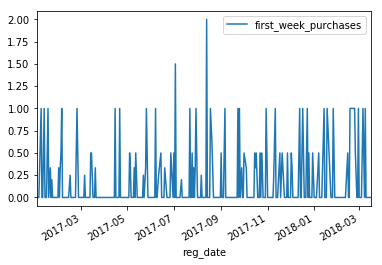

In [97]:
max_date = current_date - timedelta(days=7)
#select only users who register more than 7 days ago
filter_1 = purchase_data['reg_date'] < max_date
#select purchases within 28 days of registration
filter_2 = purchase_data['date'] <= purchase_data['reg_date'] + timedelta(days=7)
first_week_purchases = np.where((filter_1) & (filter_2), 1, np.NaN)

# Update the value in the DataFrame 
purchase_data['first_week_purchases'] = first_week_purchases

purchase_data_group = purchase_data.groupby(by=['reg_date', 'uid']).agg({'first_week_purchases': ['sum']})

# Reset the indexes
purchase_data_group.columns = purchase_data_group.columns.droplevel(level=1)
purchase_data_group.reset_index(inplace=True)

# Find the average number of purchases per day by first-week users
purchase_data_group = purchase_data_group.groupby(by=['reg_date']).agg({'first_week_purchases': ['mean']})
purchase_data_group.columns = purchase_data_group.columns.droplevel(level=1)
purchase_data_group.reset_index(inplace=True)

# Plot the results
purchase_data_group.plot(x='reg_date', y='first_week_purchases')
plt.show()

In [142]:
country_pivot = pd.pivot_table(purchase_data, values=['first_week_purchases'], columns=['country'], 
                               index=['reg_date'], fill_value=0)
country_pivot.columns = country_pivot.columns.droplevel(level=0)
country_pivot.reset_index(inplace=True)
print(country_pivot.head())

device_pivot = pd.pivot_table(purchase_data, values=['first_week_purchases'], columns=['device'], 
                              index=['reg_date'])
device_pivot.columns = device_pivot.columns.droplevel()
device_pivot.reset_index(inplace=True)
print(device_pivot.head())

country   reg_date  BRA  CAN  DEU  FRA  TUR  USA
0       2017-01-08    1    0    0    0    0    1
1       2017-01-12    0    0    0    0    1    0
2       2017-01-17    0    0    1    0    0    0
3       2017-01-20    1    0    0    0    0    0
4       2017-01-22    0    0    0    1    0    0
device   reg_date  and  iOS
0      2017-01-08  1.0  1.0
1      2017-01-12  NaN  1.0
2      2017-01-17  1.0  NaN
3      2017-01-20  NaN  1.0
4      2017-01-22  NaN  1.0


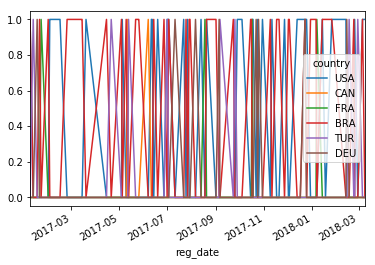

In [110]:
country_pivot.plot(x='reg_date', y=['USA', 'CAN', 'FRA', 'BRA', 'TUR', 'DEU'])
plt.show()

## 2.2 - Revenue data: 

### Trailing average: smooth

In [146]:
df = pd.read_csv('./data/AB_testing/daily_revenue.csv', parse_dates=True, infer_datetime_format=True)
df['date'] = pd.to_datetime(pd.to_datetime(df['date']).dt.date)
daily_revenue = df.groupby(by=['date'], as_index=False).agg({'revenue': ['sum']})
daily_revenue.columns = daily_revenue.columns.droplevel(level=1)
daily_revenue = daily_revenue.loc[daily_revenue['date']>'2014',:]
print(daily_revenue[:3])

          date    revenue
104 2014-01-02  1030251.0
105 2014-01-03  1006801.0
106 2014-01-04   947097.0


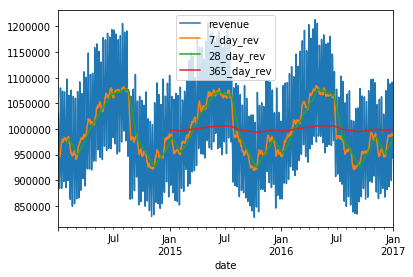

In [148]:
daily_revenue['7_day_rev'] = daily_revenue['revenue'].rolling(window=7,center=False).mean()
daily_revenue['28_day_rev'] = daily_revenue['revenue'].rolling(window=28,center=False).mean()
daily_revenue['365_day_rev'] = daily_revenue['revenue'].rolling(window=365,center=False).mean()
    
# Plot date, and revenue, along with the 3 rolling functions (in order)    
daily_revenue.plot(x='date', y=['revenue', '7_day_rev', '28_day_rev', '365_day_rev', ],linestyle='-')
plt.show()

### Exponentially moving average

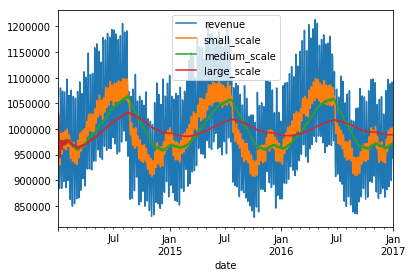

In [149]:
daily_revenue['small_scale'] = daily_revenue['revenue'].ewm(span=10).mean()
daily_revenue['medium_scale'] = daily_revenue['revenue'].ewm(span=100).mean()
daily_revenue['large_scale'] = daily_revenue['revenue'].ewm(span=500).mean()

daily_revenue.plot(x = 'date', y =['revenue', 'small_scale', 'medium_scale', 'large_scale'])
plt.show()

## 2.3 - Group revenue by month, device and gender and track evolution

       month   device  gender    revenue
0 2013-09-01  android  female  1144057.0
1 2013-09-01  android    male  3447967.0
2 2013-09-01      ios  female  1543801.0


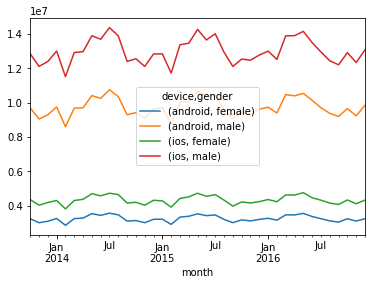

In [170]:
user_revenue = pd.read_csv('./data/AB_testing/daily_revenue.csv', parse_dates=True, infer_datetime_format=True)
user_revenue['date'] = pd.to_datetime(pd.to_datetime(user_revenue['date']).dt.date)
#user_revenue['Month'] = (str(pd.to_datetime(user_revenue['date']).dt.year) + '-' + 
#                         str(pd.to_datetime(user_revenue['date']).dt.month))
user_revenue['month'] = df['date'].values.astype('datetime64[M]')

user_revenue = user_revenue.groupby(by=['month','device', 'gender'], as_index=False).agg({'revenue': ['sum']})
user_revenue.columns = user_revenue.columns.droplevel(level=1)

# Pivot user_revenue
pivoted_data = pd.pivot_table(user_revenue, values ='revenue', columns=['device', 'gender'], index='month')
pivoted_data = pivoted_data[1:(len(pivoted_data) -1 )]

# Create and show the plot
pivoted_data.plot()
plt.show()

# 3 - Optimizing Performance - Design of A/B Tests

- Experimental units: Revenue per user day
  - check what happens when we add a paywall (requires payment to access additional content)

In [ ]:
purchase_data = demographics_data.merge(paywall_views,  how='inner', on=['uid'])
purchase_data.date = purchase_data.date.dt.floor('d')

# Group and aggregate our combined dataset 
daily_purchase_data = purchase_data.groupby(by=['date'], as_index=False)
daily_purchase_data = daily_purchase_data.agg({'purchase': ['sum', 'count']})

# Find the mean of each field and then multiply by 1000 to scale the result
daily_purchases = daily_purchase_data.purchase['sum'].mean()
daily_paywall_views = daily_purchase_data.purchase['count'].mean()
daily_purchases = daily_purchases * 1000
daily_paywall_views = daily_paywall_views * 100

print(daily_purchases)
print(daily_paywall_views)

In [192]:
daily_purchases = 3181.8
daily_paywall_views = 91731.8
conversion_rate = 0.03468

try to figure out with what precision we can measure a difference

In [193]:
small_sensitivity = 0.1

# Find the conversion rate when increased by the percentage of the sensitivity above
small_conversion_rate = conversion_rate * (1 + small_sensitivity) 

# Apply the new conversion rate to find how many more users per day that translates to
small_purchasers = daily_paywall_views * small_conversion_rate

# Subtract the initial daily_purchasers number from this new value to see the lift
purchaser_lift = small_purchasers - daily_purchases

print(small_conversion_rate)
print(small_purchasers)
print(purchaser_lift)

0.03814800000000001
3499.384706400001
317.58470640000087


check variance with our sample size

In [194]:
#n = purchase_data.purchase.count()
n = 99896
# Calculate the quantitiy "v"
v = conversion_rate * (1 - conversion_rate) 

# Calculate the variance and standard error of the estimate
var = v / n 
se = var**0.5

print(var)
print(se)

3.35121502362457e-07
0.0005788967976785301


check how power changes with sample size

In [200]:
from scipy import stats
def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    qu = stats.norm.ppf(1 - alpha/2)
    diff = abs(p2 - p1)
    bp = (p1 + p2) / 2
    v1 = p1 * (1 - p1)
    v2 = p2 * (1 - p2)
    bv = bp * (1 - bp)
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5)/(v1 + v2)**0.5)
    power = power_part_one + power_part_two
    return(power)

def get_sample_size(power, p1, p2, cl, max_n = 1000000):
    n = 1
    while n <= max_n:
        tmp_power = get_power(n, p1, p2, cl)
        if tmp_power >= power:
            return n
        else:
            n = n + 1

n1 = 1000            
p1 = 0.1  
p2 = 0.12 
cl = 0.95
# Look at the impact of sample size increase on power
n_param_one = get_power(n=1000, p1=p1, p2=p2, cl=cl)
n_param_two = get_power(n=2000, p1=p1, p2=p2, cl=cl)

# Look at the impact of confidence level increase on power
alpha_param_one = get_power(n=n1, p1=p1, p2=p2, cl=0.8)
alpha_param_two = get_power(n=n1, p1=p1, p2=p2, cl=0.95)
    
# Compare the ratios
print(n_param_two / n_param_one)
print(alpha_param_one / alpha_param_two)

1.7596440001351992
1.8857367092232278


In [ ]:
# Merge the demographics and purchase data to only include paywall views
purchase_data = demographics_data.merge(paywall_views, how='inner', on=['uid'])
                            
# Find the conversion rate
conversion_rate = (sum(purchase_data.purchase) / purchase_data.purchase.count())

# Desired Power: 0.95
# CL 0.90
# Percent Lift: 0.1
p2 = conversion_rate * (1 + 0.1)
sample_size = get_sample_size(0.95, conversion_rate, p2, 0.90)
print(sample_size)

# 4 - Data Driven Decisions - Analyzing A/B Test Results

In [201]:
ab_test_results = pd.read_csv('./data/AB_testing/AB_testing_exercise.csv')

In [202]:
# Find the unique users in each group, by device and gender
results = ab_test_results.groupby(by=['group', 'device', 'gender']).agg({'uid': pd.Series.nunique}) 

# Find the overall number of unique users using "len" and "unique"
unique_users = len(ab_test_results.uid.unique())

# Find the percentage in each group
results = results / unique_users * 100
print(results)

                           uid
group device gender           
GRP A A      F       12.239827
             M       12.795589
      I      F       12.542772
             M       12.568925
GRP B A      F       12.553669
             M       12.499183
      I      F       12.283417
             M       12.516618


In [223]:
print(ab_test_results[:3])

        uid country gender  spent  purchases        date  group device
0  11115722     MEX      F   1595          5  2016-03-08  GRP B      I
1  11122053     USA      M    498          2  2017-07-14  GRP B      I
2  11128688     USA      F   2394          6  2017-09-17  GRP A      I


In [244]:
test_conv = 0.102005
cont_conv = 0.090965
test_size = 56350
cont_size = 58583

cont_var = 1.411507925080655e-06 
test_var = 1.6255542142857143e-06

In [230]:
def get_pvalue(con_conv, test_conv, con_size, test_size):  
    lift =  - abs(test_conv - con_conv)

    scale_one = con_conv * (1 - con_conv) * (1 / con_size)
    scale_two = test_conv * (1 - test_conv) * (1 / test_size)
    scale_val = (scale_one + scale_two)**0.5

    p_value = 2 * stats.norm.cdf(lift, loc = 0, scale = scale_val )

    return p_value

In [243]:
# Get the p-value
p_value = get_pvalue(con_conv=cont_conv, test_conv=test_conv, con_size=cont_size, test_size=test_size)
print(p_value)

# Check for statistical significance
if p_value >= 0.05:
    print("Not Significant")
else:
    print("Significant Result")

nan
Significant Result


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [238]:
def get_ci(value, cl, sd):
    loc = stats.norm.ppf(1 - cl/2)
    rng_val = stats.norm.cdf(loc - value/sd)

    lwr_bnd = value - rng_val
    upr_bnd = value + rng_val 

    return_val = (lwr_bnd, upr_bnd)
    return(return_val)

In [239]:
# Calculate the mean of our lift distribution 
lift_mean = test_conv - cont_conv

# Calculate variance and standard deviation 
lift_variance = (1 - test_conv) * test_conv /test_size + (1 - cont_conv) * cont_conv / cont_size
lift_sd = lift_variance**0.5

# Find the confidence intervals with cl = 0.95
confidence_interval = get_ci(lift_mean, 0.95, lift_sd)
lwr_ci = confidence_interval[0]
upr_ci = confidence_interval[1]
print(confidence_interval)

(0.011039999822042502, 0.011040000177957487)


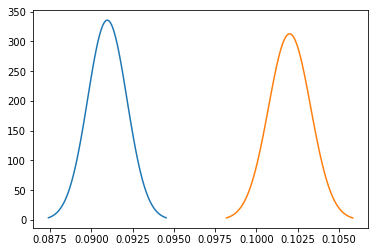

In [240]:
# Compute the standard deviations
control_sd = cont_var**0.5
test_sd = test_var**0.5

# Create the range of x values 
control_line = np.linspace( cont_conv - 3 * control_sd, cont_conv + 3 * control_sd , 100)
test_line = np.linspace( test_conv - 3 * test_sd,  test_conv + 3 * test_sd , 100)

# Plot the distribution 
plt.plot(control_line, stats.norm.pdf(control_line, cont_conv, control_sd))
plt.plot(test_line, stats.norm.pdf(test_line,test_conv, test_sd))
plt.show()

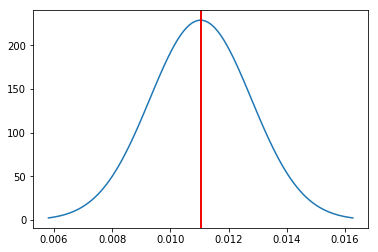

In [241]:
# Find the lift mean and standard deviation
lift_mean = test_conv - cont_conv
lift_sd = (test_var + cont_var) ** 0.5

# Generate the range of x-values
lift_line = np.linspace(lift_mean - 3 * lift_sd, lift_mean + 3 * lift_sd, 100)

# Plot the lift distribution
plt.plot(lift_line, stats.norm.pdf(lift_line, lift_mean, lift_sd))

# Add the annotation lines
plt.axvline(x = lift_mean, color = 'green')
plt.axvline(x = lwr_ci, color = 'red')
plt.axvline(x = upr_ci, color = 'red')
plt.show()